In [1]:
# Set imports
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler

### DataSet: Magic Gamma Telescope

Dua, D. and Graff, C. (2019), UCI Machine Learning Repository ['http://archive.ics.uci.edu/ml]. Irvine, CA: Univeristy of California, School of Information and Computer Sciences.

Donated By: P.Savicky Institute of Computer Science, AS of CR Czech Republic savicky '@' cs.cas.cz

### General Setup Cleaning and Transforming Data

In [2]:
# Extract Column Name
cols =["fLength","fWidth","fSize","fConc","fConc1","fAsym","fm3Long", "fM3Trans","fAlpha","fDist","class"]

# Read data and apply names
df = pd.read_csv("DataSets/magicGammaTelescope/magic04.data", names=cols)

# Print the head to check
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fm3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


To help group and classify we take a dimension using an unchanging classifier (class) <br>
Changing Class Gamma/Hadron (g or h) to Numerical Data (1 or 0)

In [3]:
# rewrite class column as numeric and check head for alteration
df["class"] = (df["class"] == "g").astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fm3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


For Each Label Name up to class ([:-1]); Compare Each Attribute Grouping By 'Class' 

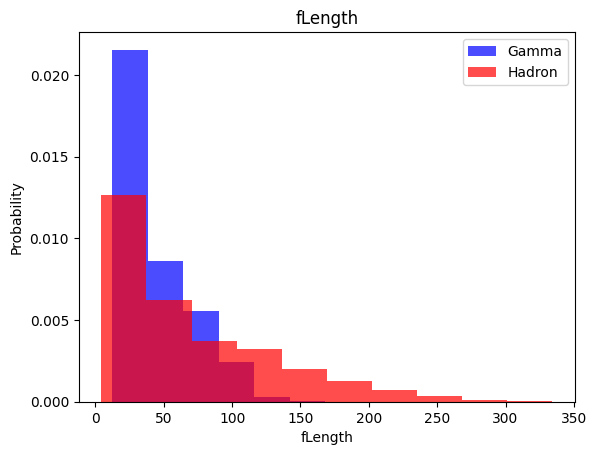

Label: fLength


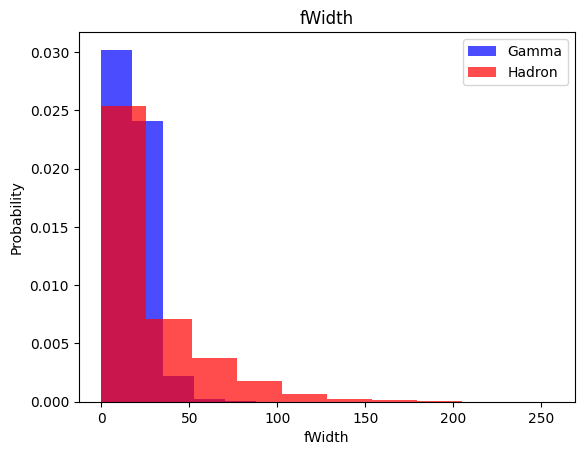

Label: fWidth


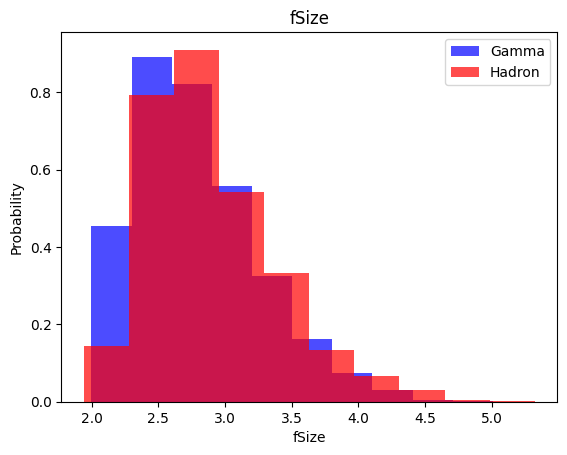

Label: fSize


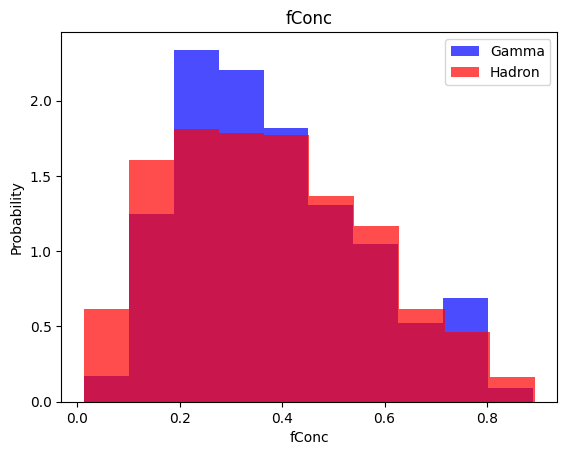

Label: fConc


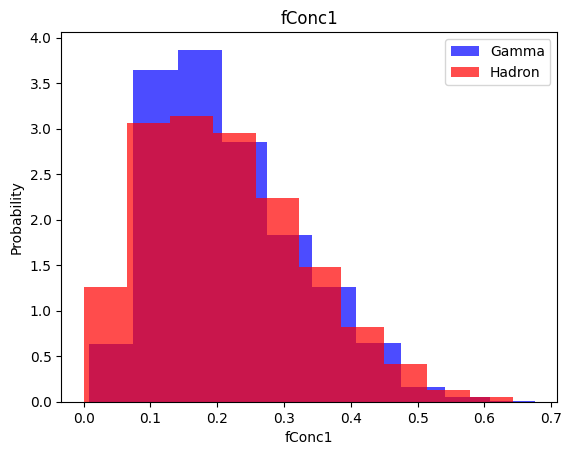

Label: fConc1


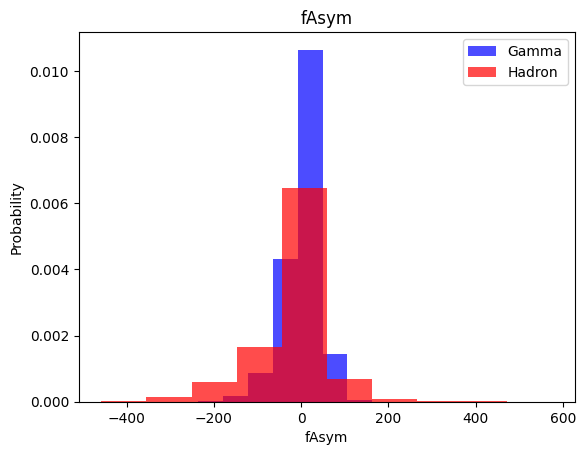

Label: fAsym


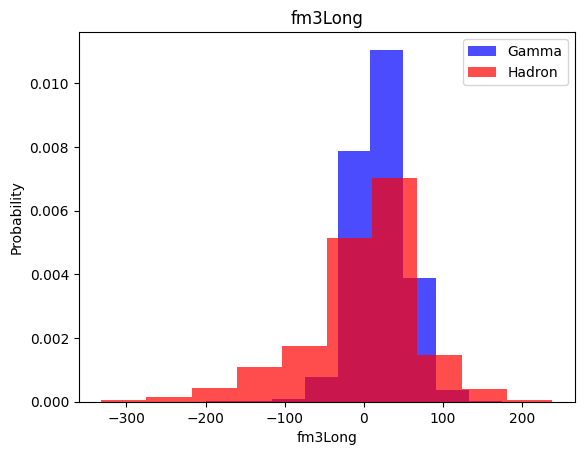

Label: fm3Long


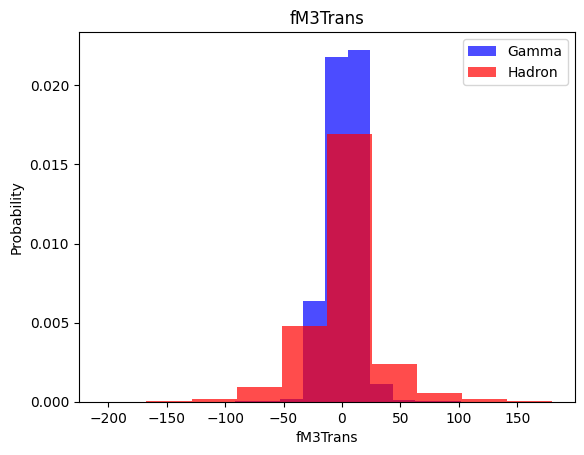

Label: fM3Trans


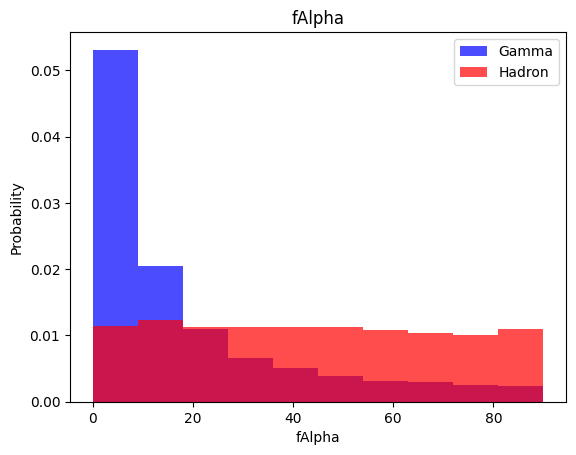

Label: fAlpha


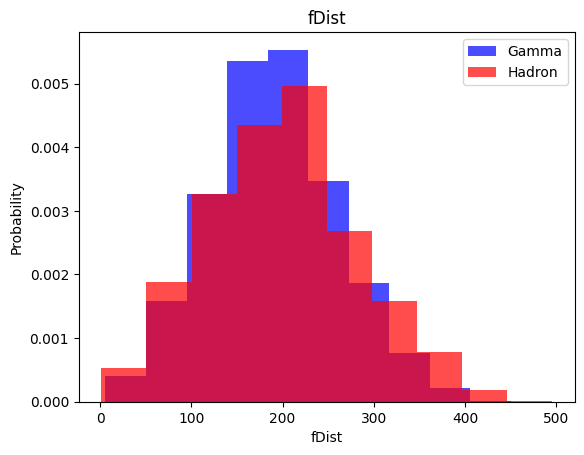

Label: fDist


In [4]:
# This allows us to split our data and then make more meaningful comparisons based on the remaining dimensions
for label in cols[:-1]:

    # Make a histogram of class; Gamma = 1, Hadron = 0, Generic Alpha, and Density Even Dist
    plt.hist(df[df["class"]==1][label], color='blue', label='Gamma', alpha=0.7, density=True)
    plt.hist(df[df["class"]==0][label], color='red', label='Hadron', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

    print("Label: " + label)

    

### Setup Vars for Train,Validate,Test
1st Seg: 0 -> 60% - Training Data <br>
2nd Seg: 60% -> 80% - Validation Data <br>
3rd Seg: 80 -> 100% - Testing Data <br>

In [5]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Data of Different Scale.
EX: col1HighestValue === 5 vs. col2HighestValue === 5000000 ** This Difference is too large for plots to work when compared *** <br>
We create a method to scale the data and shape any incorrectly dimensioned dataframes

In [6]:
def scale_dataset(dataframe, oversample=False):

    # get all values assuming label is last
    X = dataframe[dataframe.columns[:-1]].values
    # get labels
    y = dataframe[dataframe.columns[-1]].values

    # create imported scaler
    scaler = StandardScaler()
    # fit and transform to make x fit
    X = scaler.fit_transform(X)

    # If there is an oversample use package randomoversampler, and refit
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X,y)

    # into a new data frame put reshaped data (data reshaping due to X is 2d, and y is a 1d vector) and horizontally stack them. side by side
    data = np.hstack((X, np.reshape(y, (-1,1))))

    return data, X, y

Scale Dataset, Training, Validtion, and Testing; Ready For Simple Built-In Scikit-Learn Models

In [7]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

After applying any scaling and compensating for oversampling or any outliers. We can apply out base models

### Model 1: K-Nearest Neighbors (K-NN)

The K-Nearest Neighbors (KNN) algorithm is used for classification/regression tasks. It's idea that similar data points tend to have similar labels or values. Think you get similar recommendations as a person who is similar to you, in a vague comparison.

In [8]:
# Created a model, parem - amount of nearest neighbors
knn_model = KNeighborsClassifier(n_neighbors=2)

# fit using X_train, and y_train data
knn_model = knn_model.fit(X_train, y_train)


### Classification Report (K-NearestNeighbors)

In [9]:
# PREDICTION - First Prediction
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Precision - How many of our labeling are confirmed to be True Positives
# 1st Test .77, .84; 1-n_neighbors
# 2nd Test .67, .87; 2-n_neighbors

# Recall - Of all that are truly positive how many do we actually get correct.
# 1st Test .68, .89; 1-n_neighbors
# 2nd Test .78, .80; 2-n_neighbors

# Accuracy - If we look at pure correct vs total.
# 1st Test .82; 1-n_neighbors
# 2nd Test .79; 2-n_neighbors

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1323
           1       0.88      0.81      0.84      2481

    accuracy                           0.80      3804
   macro avg       0.78      0.80      0.79      3804
weighted avg       0.81      0.80      0.80      3804



### Model 2: Naive-Bayes

In [10]:
# Naive-Bayes Gaussian Model; Named after the Mathematician as we do.
# Gaussian being on a normal distribution and Naive Bayes indicating each feature being independent of the value of the class variable
# In this case. each dimension (e.g. fSize is independent of the class associated with it.)
# Then it all falls under the normal distribution curve.
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

### Classification Report (Gaussian Naive-Bayes)

In [11]:
# PREDICTION - Notice Everything is variating from our previous method.
y_pred = nb_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.40      0.50      1323
           1       0.74      0.90      0.81      2481

    accuracy                           0.72      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.72      0.70      3804



### Model 3: Logistic Regression

In [12]:
# Logistic Regression Model; Multiple Logistic Regression 
# After taking a logistic regression and converting to a Sigmoid Function to keep within the realms of probability (0 -> 1).
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_train, y_train)

### Classification Report (Logistic Regression)

In [13]:
# PREDICTION - Notice Everything is variating from our previous method. little different. Result may vary
y_pred = lr_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1323
           1       0.85      0.83      0.84      2481

    accuracy                           0.79      3804
   macro avg       0.77      0.78      0.77      3804
weighted avg       0.79      0.79      0.79      3804



### Model 3: Support Vector Machine

In [14]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

### Classification Report (Support Vector Machine)

In [15]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1323
           1       0.89      0.90      0.90      2481

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



### Can we beat a common result, ~80%? Lets try Neural Networks

Take all of the features and turn them into inputs by giving them a weight value. <br>
Multiply the features and Sum "Insert Epsilon Here" and this is the Neuron. <br>
Add bias if needed. <br>
Then after all this comes together it is processed via ActivationFunction to get out output. <br><br>

*Note* without the ActivationFunction. This is a LinearModel.<br>
Examples include Sigmoid Functions (val from 0 -> 1), Tanh (val from -1 -> 1), and RELU (any val<0 = 0 -> val=Linear)<br><br>

Features x0, x1, x2<br>
Weighting w0, w1, w2<br>

[x0] *= w0<br>
[x1] *= w1<br>
[x2] *= w2<br>

[xT] = [x0] + [x1] + [x2] <br>

[xT] += BIAS -> AF() -> *** OUTPUT *** <br>

### Let's Go! Tensor Flow!

### Model 4: TensorFlow Neural Networks

In [16]:
# Nueral net model shouold be layered that I pass in as a model
# Using a dense layer of 32 units
def train_model(X_train, y_train, numNodes, dropoutProb, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([

        tf.keras.layers.Flatten(input_shape=(10, )),

        # layer of shape; density is numbe of nodes per layer
        tf.keras.layers.Dense(numNodes, activation='relu'),

        # Helps prevent overfitting by selectively leaving out certain samples
        tf.keras.layers.Dropout(dropoutProb),
        
        #second layer of no shape
        tf.keras.layers.Dense(numNodes, activation='relu'),

        # Helps prevent overfitting by selectively leaving out certain samples
        tf.keras.layers.Dropout(dropoutProb),

        
        # third layer of sigmoid (project our predictions to be 0 or 1)
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    # Each epoch leave x% out and see how the model performs on the % segment taken out of the training
    # this is validation split
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return nn_model, history

In [17]:
# Lets plot
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.show()

Display Tensor Flow Through PyPlot

nodes 16, dropout 0, lr 0.1, batch size 32
Epoch 1/100


C:\Users\BabyLogan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.7960 - loss: 0.4609 - val_accuracy: 0.6771 - val_loss: 0.5065
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8417 - loss: 0.3905 - val_accuracy: 0.5695 - val_loss: 0.5573
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8318 - loss: 0.3963 - val_accuracy: 0.7520 - val_loss: 0.4412
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8488 - loss: 0.3773 - val_accuracy: 0.7371 - val_loss: 0.5613
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.8468 - loss: 0.3694 - val_accuracy: 0.6699 - val_loss: 0.6279
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8515 - loss: 0.3663 - val_accuracy: 0.7334 - val_loss: 0.4765
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.8535 - loss: 0.3584 - val_accuracy: 0.5139 - val_loss: 0.8814
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8509 - loss: 0.3603 - val_

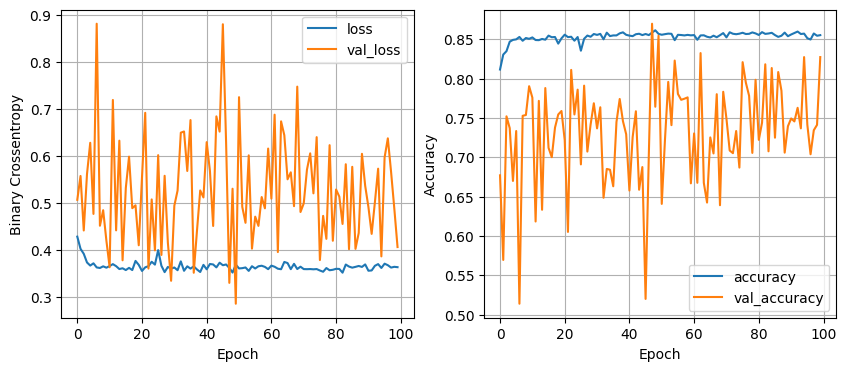

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.8261 - loss: 0.4346
nodes 16, dropout 0, lr 0.1, batch size 64
Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.7880 - loss: 0.4500 - val_accuracy: 0.7670 - val_loss: 0.4196
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.8441 - loss: 0.3744 - val_accuracy: 0.7293 - val_loss: 0.4821
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.8428 - loss: 0.3670 - val_accuracy: 0.7293 - val_loss: 0.4439
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8520 - loss: 0.3550 - val_accuracy: 0.7782 - val_loss: 0.4894
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8517 - loss: 0.3588 - val_accuracy: 0.7330 - val_loss: 0.5535
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8411 - loss: 0.3759 - val_accuracy: 0.7110 - val_loss: 0.5070
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8551 - loss: 0.3549 - val

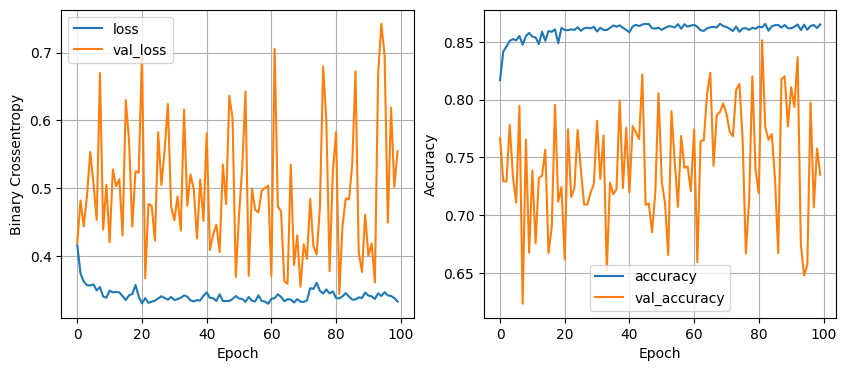

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - accuracy: 0.8621 - loss: 0.3435
nodes 16, dropout 0, lr 0.1, batch size 128
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7628 - loss: 0.4751 - val_accuracy: 0.7541 - val_loss: 0.4645
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.8470 - loss: 0.3557 - val_accuracy: 0.7843 - val_loss: 0.4658
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.8496 - loss: 0.3530 - val_accuracy: 0.6764 - val_loss: 0.5801
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.8418 - loss: 0.3684 - val_accuracy: 0.6974 - val_loss: 0.5241
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.8567 - loss: 0.3450 - val_accuracy: 0.6703 - val_loss: 0.6889
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.8504 - loss: 0.3561 - val_accuracy: 0.7381 - val_loss: 0.4688
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8612 - loss: 0.3329 - val_accuracy: 0.74

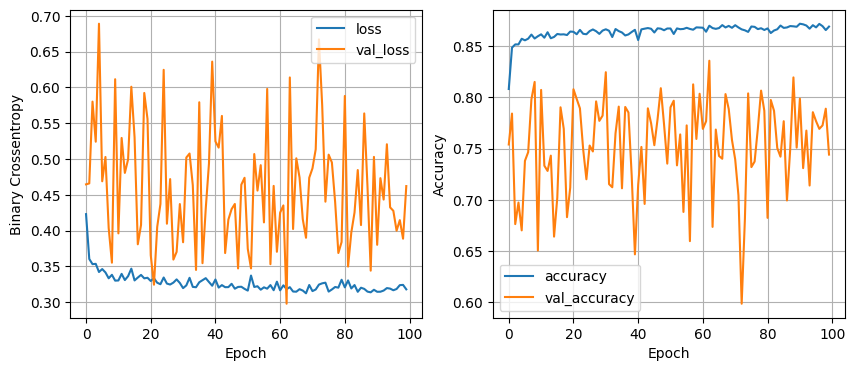

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.8657 - loss: 0.3189
nodes 16, dropout 0, lr 0.005, batch size 32
Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.7573 - loss: 0.4861 - val_accuracy: 0.7385 - val_loss: 0.5312
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8511 - loss: 0.3533 - val_accuracy: 0.7415 - val_loss: 0.5085
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8589 - loss: 0.3361 - val_accuracy: 0.7140 - val_loss: 0.5592
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.8614 - loss: 0.3274 - val_accuracy: 0.7619 - val_loss: 0.4446
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8657 - loss: 0.3248 - val_accuracy: 0.7809 - val_loss: 0.3995
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.8712 - loss: 0.3147 - val_accuracy: 0.7185 - val_loss: 0.5092
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.8659 - loss: 0.3198 - v

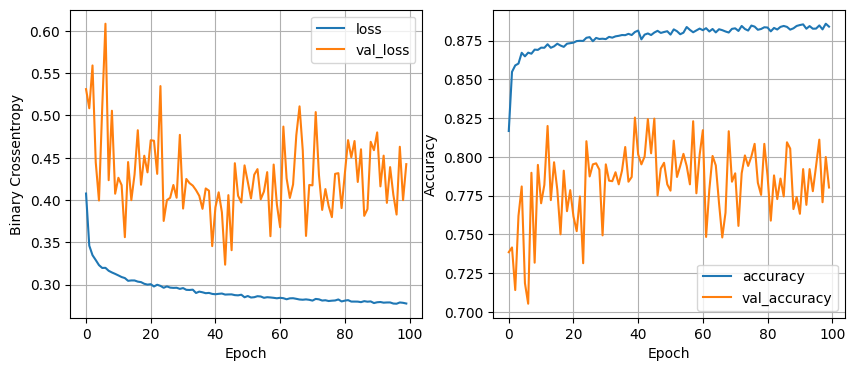

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.8769 - loss: 0.3065
nodes 16, dropout 0, lr 0.005, batch size 64
Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.7744 - loss: 0.4698 - val_accuracy: 0.6859 - val_loss: 0.5832
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8429 - loss: 0.3669 - val_accuracy: 0.7761 - val_loss: 0.4511
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.8582 - loss: 0.3329 - val_accuracy: 0.7239 - val_loss: 0.5351
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.8603 - loss: 0.3357 - val_accuracy: 0.7683 - val_loss: 0.4380
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8605 - loss: 0.3321 - val_accuracy: 0.7364 - val_loss: 0.5298
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8627 - loss: 0.3226 - val_accuracy: 0.7632 - val_loss: 0.4508
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8679 - loss: 0.3133 - v

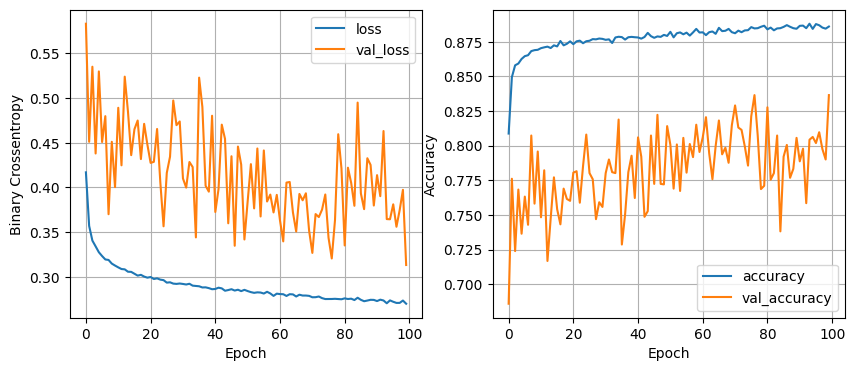

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.8551 - loss: 0.3343
nodes 16, dropout 0, lr 0.005, batch size 128
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7058 - loss: 0.5484 - val_accuracy: 0.7052 - val_loss: 0.5148
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.8316 - loss: 0.3867 - val_accuracy: 0.7510 - val_loss: 0.4960
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.8578 - loss: 0.3474 - val_accuracy: 0.7724 - val_loss: 0.4553
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.8590 - loss: 0.3395 - val_accuracy: 0.7887 - val_loss: 0.4298
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8616 - loss: 0.3297 - val_accuracy: 0.7497 - val_loss: 0.5032
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8618 - loss: 0.3272 - val_accuracy: 0.7704 - val_loss: 0.4596
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.8676 - loss: 0.3206 - val_accuracy: 0.

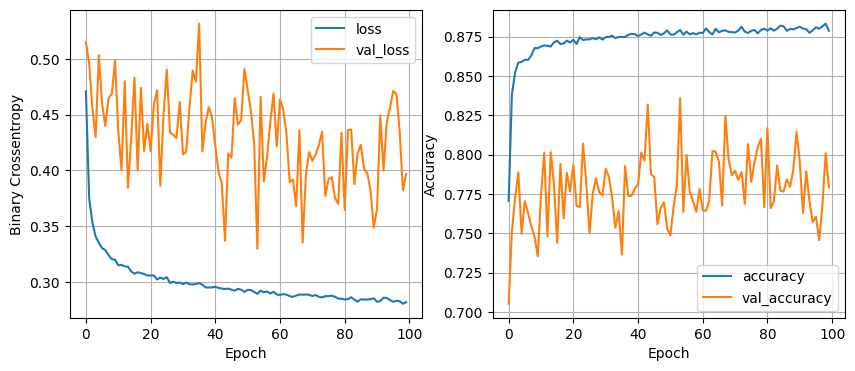

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.8667 - loss: 0.3163
nodes 16, dropout 0, lr 0.001, batch size 32
Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.6755 - loss: 0.5920 - val_accuracy: 0.6309 - val_loss: 0.6302
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8275 - loss: 0.3911 - val_accuracy: 0.7208 - val_loss: 0.5234
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.8430 - loss: 0.3672 - val_accuracy: 0.7083 - val_loss: 0.5425
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8444 - loss: 0.3652 - val_accuracy: 0.7208 - val_loss: 0.5357
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8481 - loss: 0.3575 - val_accuracy: 0.7361 - val_loss: 0.5086
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8525 - loss: 0.3484 - val_accuracy: 0.7391 - val_loss: 0.5113
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8570 - loss: 0.3451 - v

In [18]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.1, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"nodes {num_nodes}, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot_history(history)
                val_loss = model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

### Classification Results (TensorFlow Keras)

In [ ]:
# Do precision and Accuracy Go Up? Maybe
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1, )
print(classification_report(y_test, y_pred))

### Model 5 Linear Regression

Assume: <br>
&emsp;&emsp;The data is linear when plotted via scatterPlot <br>
&emsp;&emsp;Each sample is independant <br>
&emsp;&emsp;Should have Normal Homoscedasticity <br>
&emsp;&emsp;Should it not have Homoscedasticity; The Risudual Plot Funnels in Shape <br>
&emsp;&emsp;(Risidual Plot Shape = >) || (Risidual Plot Shape = >) <br>
&emsp;&emsp;Maybe don't use linear regression <br>


### Evaluating A Linear Regression Model

1 - Mean Absolute Error <br>
&emsp;&emsp;* Lets take all of the errors/residuals, sum the distance, take the average <br>
&emsp;&emsp;* This says how far off we are <br>
&emsp;&emsp;* $\displaystyle \Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|}{n}\Bigg]$ <br><br>

2 - Mean Squared Error <br>
&emsp;&emsp;* Same concept but to punish distance from linear model more harshly <br>
&emsp;&emsp;* To do this we square the summation <br>
&emsp;&emsp;* This is good for removing outliers as they will face a more intense value weighting. <br>
&emsp;&emsp;* $\displaystyle \Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|^{2}}{n}\Bigg]$ <br><br>

3 - Root Mean Squared Error <br>
&emsp;&emsp;* Same concept but to punish distance from linear model more harshly <br>
&emsp;&emsp;* To do this we square the summation <br>
&emsp;&emsp;* This is good for more direct comparison to Y. The root mean squared provides an easier y comparion <br>
&emsp;&emsp;* $\displaystyle \sqrt{\Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|^{2}}{n}\Bigg]}$<br><br>

4 - Coefficient of Determination <br>
&emsp;&emsp;* RSS - Sum of Squared Residuals -> The Numerator in the Above Functions<br>
&emsp;&emsp;* TSS - Total Sum of Squares<br><br>
&emsp;&emsp;* TSS = $\displaystyle \sum \limits _{i=1} ^{n} |y_{i} - \bar{y_{i}}|^{2}$<br><br>
&emsp;&emsp;* Notice Instead of predicted value '^' we use average/mean value '-'<br>
&emsp;&emsp;* A value close to 0 with $R^{2}$ is a good indicator usually<br><br>
&emsp;&emsp;* $R^{2} = 1 - \Bigg[\frac{RSS}{TSS}\Bigg]$ <br><br>
